## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import random

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

import scipy
import sklearn.model_selection as skl
from sklearn.utils import class_weight

import tensorflow as tf
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, Reshape
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix, accuracy_score

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(20)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
94053,00023853_000.png,Fibrosis,0,23853,55,M,PA,2986,2917,0.143,0.143,NaN,/data/images_010/images/00023853_000.png
69804,00017207_013.png,Edema|Infiltration,13,17207,57,M,AP,2500,2048,0.168,0.168,NaN,/data/images_008/images/00017207_013.png
14646,00003809_000.png,No Finding,0,3809,40,M,PA,2500,2048,0.168,0.168,NaN,/data/images_002/images/00003809_000.png
41475,00010722_005.png,No Finding,5,10722,48,M,PA,2992,2991,0.143,0.143,NaN,/data/images_005/images/00010722_005.png
91453,00022815_074.png,Atelectasis|Edema|Infiltration,74,22815,9,M,AP,2544,3056,0.139,0.139,NaN,/data/images_010/images/00022815_074.png
26353,00006918_000.png,No Finding,0,6918,27,F,PA,2500,2048,0.171,0.171,NaN,/data/images_004/images/00006918_000.png
103233,00027526_000.png,No Finding,0,27526,55,F,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00027526_000.png
621,00000152_000.png,No Finding,0,152,65,M,PA,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000152_000.png
79880,00019629_000.png,Mass,0,19629,54,M,PA,2992,2991,0.143,0.143,NaN,/data/images_009/images/00019629_000.png
30776,00008025_000.png,No Finding,0,8025,29,F,PA,2048,2500,0.168,0.168,NaN,/data/images_004/images/00008025_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
#all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print('All Labels', all_labels)

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(20)





All Labels ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
104978,00028165_000.png,Infiltration,0,28165,35,M,PA,3056,2544,0.139000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
57001,00014153_003.png,Mass,3,14153,36,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14966,00003914_002.png,Cardiomegaly|Effusion,2,3914,35,F,PA,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31601,00008261_000.png,No Finding,0,8261,39,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
91468,00022816_008.png,Infiltration,8,22816,49,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
72953,00017976_000.png,No Finding,0,17976,57,M,PA,2812,2500,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
65111,00016074_011.png,Atelectasis,11,16074,43,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22467,00005962_019.png,Atelectasis,19,5962,32,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107679,00029102_000.png,No Finding,0,29102,24,F,PA,1603,1740,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9278,00002419_003.png,Mass,3,2419,45,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = ['Normal' if x == 0.0 else 'Pneumonia' for x in all_xray_df['Pneumonia']]  #all_xray_df['Pneumonia'] == 1.0
#['Peumonia' if x == '1.0' else 'Normal' for x in all_xray_df['Pneumonia']] 
all_xray_df.sample(4)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
8591,00002274_003.png,No Finding,3,2274,51,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Normal
73087,00018006_004.png,Effusion,4,18006,60,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
50537,00012816_000.png,No Finding,0,12816,63,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Normal
68112,00016805_014.png,Atelectasis|Consolidation|Effusion|Emphysema|I...,14,16805,67,F,PA,2550,2991,0.143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Normal


## Create your training and testing data:

In [5]:
def create_splits(all_xray_df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = skl.train_test_split(all_xray_df, test_size=0.2, stratify = all_xray_df['Pneumonia'])
    
    positive_cases = train_data[train_data['Pneumonia'] ==1].index.tolist()
    negative_cases = train_data[train_data['Pneumonia'] ==0].index.tolist()
    # Creating the training set as a balanced once
    train_data = train_data.loc[positive_cases + random.sample(negative_cases, len(positive_cases)) ]
    
    positive_cases = val_data[val_data['Pneumonia'] ==1].index.tolist()
    negative_cases = val_data[val_data['Pneumonia'] ==0].index.tolist()
    # 80% of the validation data to be (No Pneumonia)
    val_data_neg = 4 * len(positive_cases)
    # Creating the Validation set as imbalanced one
    val_data = val_data.loc[positive_cases + random.sample(negative_cases, val_data_neg)]
    
    return train_data, val_data
    
train_data, val_data = create_splits(all_xray_df)
print(len(train_data[train_data['Pneumonia']==1]))
print(len(train_data[train_data['Pneumonia']==0]))
print(len(val_data[val_data['Pneumonia']==1]))
print(len(val_data[val_data['Pneumonia']==0]))

1145
1145
286
1144


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [6]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo

    my_idg = ImageDataGenerator(rescale = 1./255,
                                width_shift_range = 0.1,
                                height_shift_range = 0.1,
                                shear_range= 0.1,
                                zoom_range = 0.1,
                                horizontal_flip = True,
                               vertical_flip  = False,
                               rotation_range = 20)
    
    return my_idg


def make_train_gen(train_data):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    augmented_data = my_image_augmentation()
    train_gen =  augmented_data.flow_from_dataframe(dataframe = train_data,
                                                   directory = None,
                                                   x_col = "path",
                                                   y_col = "Pneumonia",
                                                   target_size= (224,224),
                                                   batch_size = 64,
                                                   class_mode = "raw",            
                                                  )

    return train_gen


def make_val_gen(test_data):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    val_data_gen =   ImageDataGenerator(rescale = 1./255)
    val_gen = val_data_gen.flow_from_dataframe(dataframe = test_data,
                                               directory = None,
                                                x_col = "path",
                                                y_col = "Pneumonia",
#                                                has_ext = True,
                                                target_size= (224,224),
                                                batch_size = 64,
                                                class_mode = "raw",            
                                                  )
                                               
                                               
    return val_gen

train_data, test_data = create_splits(all_xray_df)
#train_data.info()
# Create train data generator
train_gen = make_train_gen(train_data)

# Create test data generator
val_gen = make_val_gen(test_data)

Found 2290 validated image filenames.
Found 1430 validated image filenames.


In [7]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()
print('len of val_gen', len(val_gen))
print('len of ValX = ', len(valX))
print('ValY = ', valY)
print('len of ValY = ', len(valY))

len of val_gen 23
len of ValX =  64
ValY =  [0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
len of ValY =  64


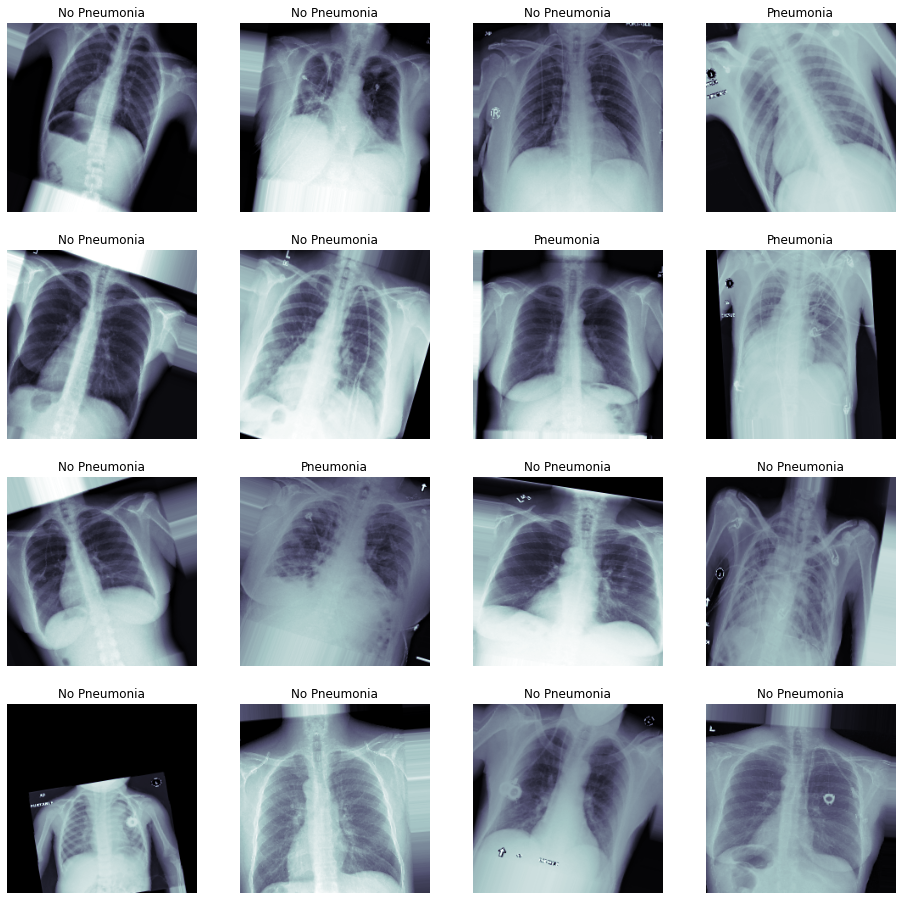

In [8]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [9]:
def load_pretrained_model():
    # Download the VGG16 pre-trained model with imagenet dataset
    model = VGG16(include_top= True , weights='imagenet')
    # Get out the final layer to add our layer later 
    transfer_layer = model.get_layer('block5_pool')  
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    return vgg_model
VGG_model_trial = load_pretrained_model()
VGG_model_trial.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [10]:
def build_my_model(VGG16_Conv_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    # Building the model with transfer learning and added new layer for classification
    my_model = Sequential()
    
    vgg16_model = load_pretrained_model()
    
    # Addig from the above the VGG16 model 
    my_model.add(VGG16_Conv_model)
    
    # FC layer
    # Flatten the VGG16 model output  -- shape of last block = (7,7,512)
    my_model.add(Flatten())
      
    # Add the fully-connected layer (Dense layer) - To combine the recongized feature by VGG16
    my_model.add(Dense(1024, activation = 'relu'))
    
    # Add the droup-out layer to avoid overfitting
    my_model.add(Dropout(0.2))
      
    # Add a final sigmoid layer for classification
    my_model.add(Dense(1, activation= 'sigmoid'))
      
    return my_model

#build_my_model(VGG_model)

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [11]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model6.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                              mode= 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'auto', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [12]:
### train your model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
# Todo

# 1. Split the dataframe
#train_data, test_data = create_splits(all_xray_df)
#print(len(train_data))
#print(len(test_data))
#num_train_samples = len(train_data)
#num_val_samples = len(test_data)
#batch_size = 10
# 2. Create train data generator
#train_gen = make_train_gen(train_data)

# 3. Create test data generator
#validation_data = make_val_gen(test_data)


# 4. Plot the a visualization graph of the data
#all_xray_df.pneumonia_class.value_counts().plot(kind='bar')
#plt.title('Pneumonia_Class')
#plt.xlabel('Pneumonia Cases Binary')
#plt.ylabel('Count')
#plt.show()

# 5. Loading and using predefined model
#VGG16_Conv_model = load_pretrained_model()
#print(VGG16_Conv_model.summary())

# 6. Build and train the model
#my_model = build_my_model(VGG16_Conv_model)

#my_model.summary()

# 8. Saving the model after training 

#json_file = open("my_model.json", "r")
#loaded_model_json = json_file.read()
#json_file.close()
#my_model = model_from_json(loaded_model_json)
#my_model.load_weights(weight_path)

# 9. Serialize the model to .JSON

#my_model_json = my_model.to_json()
#with open("my_model.json",w) as json_file:
#    json_file.write(my_model_json)

 #10. Serialize the model to h5
#my_model.save_weights("my_mode_weights.h5")


# 1. Loading and using predefined model
VGG16_Conv_model = load_pretrained_model()

# 2. Building the model starting from the VGG16 model
my_model = build_my_model(VGG16_Conv_model)

# Define the optimier - loss function - Metrics
optimizer = Adam(lr=0.0001, decay=1e-5)
loss_fun ='binary_crossentropy'
metrics = ['acc']
    
my_model.compile(loss= loss_fun ,optimizer = optimizer,metrics = metrics)


# 10. Model History
history = my_model.fit_generator(train_gen,
                                 validation_data = (valX, valY),
                                 epochs = 10,
                                 callbacks = callbacks_list)





Epoch 1/10
36/36 [==============================] - 68s 2s/step - loss: 0.7998 - acc: 0.5367 - val_loss: 0.6515 - val_acc: 0.6719

Epoch 00001: val_loss improved from inf to 0.65152, saving model to xray_class_my_model6.best.hdf5
Epoch 2/10
36/36 [==============================] - 63s 2s/step - loss: 0.6670 - acc: 0.6013 - val_loss: 0.6358 - val_acc: 0.6250

Epoch 00002: val_loss improved from 0.65152 to 0.63582, saving model to xray_class_my_model6.best.hdf5
Epoch 3/10
36/36 [==============================] - 59s 2s/step - loss: 0.6695 - acc: 0.6031 - val_loss: 0.5217 - val_acc: 0.7344

Epoch 00003: val_loss improved from 0.63582 to 0.52173, saving model to xray_class_my_model6.best.hdf5
Epoch 4/10
36/36 [==============================] - 61s 2s/step - loss: 0.6445 - acc: 0.6376 - val_loss: 0.5170 - val_acc: 0.7500

Epoch 00004: val_loss improved from 0.52173 to 0.51699, saving model to xray_class_my_model6.best.hdf5
Epoch 5/10
36/36 [==============================] - 60s 2s/step - lo

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [13]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
from keras.models import load_model

my_model.load_weights("xray_class_my_model6.best.hdf5")

#valX, Valy = validation_data.next()

pred_Y = my_model.predict(valX, batch_size = 64, verbose = True)

#print(pred_Y)

64/64 [==============================] - 1s 11ms/step


In [14]:
import sklearn.metrics as metrics
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix, accuracy_score
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fpr, tpr, threshold = roc_curve(valY, pred_Y)
    roc_auc = auc(fpr,tpr)
    
    plt.title('AUC')
    plt.plot(fpr,tpr,'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Rate')
    plt.xlabel('False Rate')
    plt.show()
    return

## what other performance statistics do you want to include here besides AUC? 


def plot_history(history):
    plt.figure()
    plt.plot( np.arange(len(history.history["loss"])) ,  history.history["loss"]  , label = "training Loss" )
    plt.plot( np.arange(len(history.history["loss"])) ,  history.history["val_loss"] , label = "Validation Loss" )
    plt.title("Dataset - Training Vs Validation")
    plt.xlabel("Number of Epoches")
    plt.ylabel("Loss")
    plt.legend(loc = "upper left")
    return
    
def plot_precPrec(valY, pred_Y):
    prec, rec, threshold = precision_recall_curve(valY, pred_Y)
    plt.title('Plot Precision Recall')
    plt.plot(prec, rec, 'b', label = 'score = %0.2f' % average_precision_score(valY,pred_Y))
    plt.legend(loc = 'upper right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)


def plot_f1_thre(t_y, p_y):
    prec, rec, threshold = precision_recall_curve(t_y, p_y)
    plt.title('Plot f1 score vs Threshold')
    plt.plot(calc_f1(prec[:-1],rec[:-1]),threshold , 'b', label = 'score = %0.2f' % average_precision_score(valY,pred_Y))
    plt.legend(loc = 'upper right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('F1 Score')
    plt.ylabel('Threshold')
    plt.show()

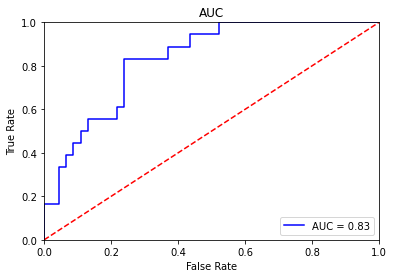

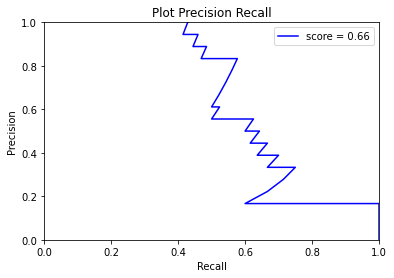

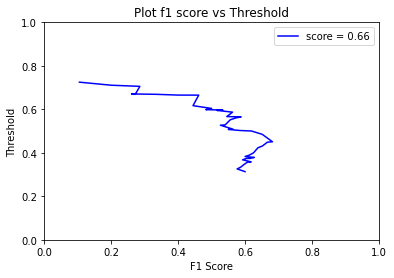

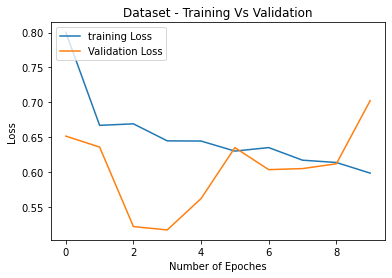

In [15]:
## plot figures

# Todo
plot_auc(valY, pred_Y)
plot_precPrec(valY, pred_Y)
plot_f1_thre(valY, pred_Y)
plot_history(history)


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [19]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
#predicts = my_model.predict(validation_data)

#accuracy = accuracy_score

# Loading the model again to complete evaluation
import keras
from keras.models import load_model
with open('my_model6.json','r') as json_file:
    Model_json = json_file.read()
model = keras.models.model_from_json(Model_json)
model.load_weights("xray_class_my_model6.best.hdf5")

model.load_weights("xray_class_my_model6.best.hdf5")
pred_Y = model.predict(valX, batch_size = 64, verbose = True)


def optimize_perormance(ValY , Pred_Y):
    final_threshold = 0
    final_acc = 0
    for x in np.arange(0.5, 1, 0.1):
        pred = (Pred_Y.reshape(-1) > x)*1.0
        acc = np.mean(pred == ValY)
        if acc > final_acc:
            final_threshold = x
            final_acc = acc
    return final_threshold, final_acc

Final_Threshold, Final_accuracy = optimize_perormance(valY , pred_Y)
print(" Threshold = ", Final_Threshold)
print(" Accuracy = ", Final_accuracy)
pred_class = pred_Y > Final_Threshold
f1_value = f1_score(valY, pred_class)


64/64 [==============================] - 1s 11ms/step
 Threshold =  0.6
 Accuracy =  0.78125


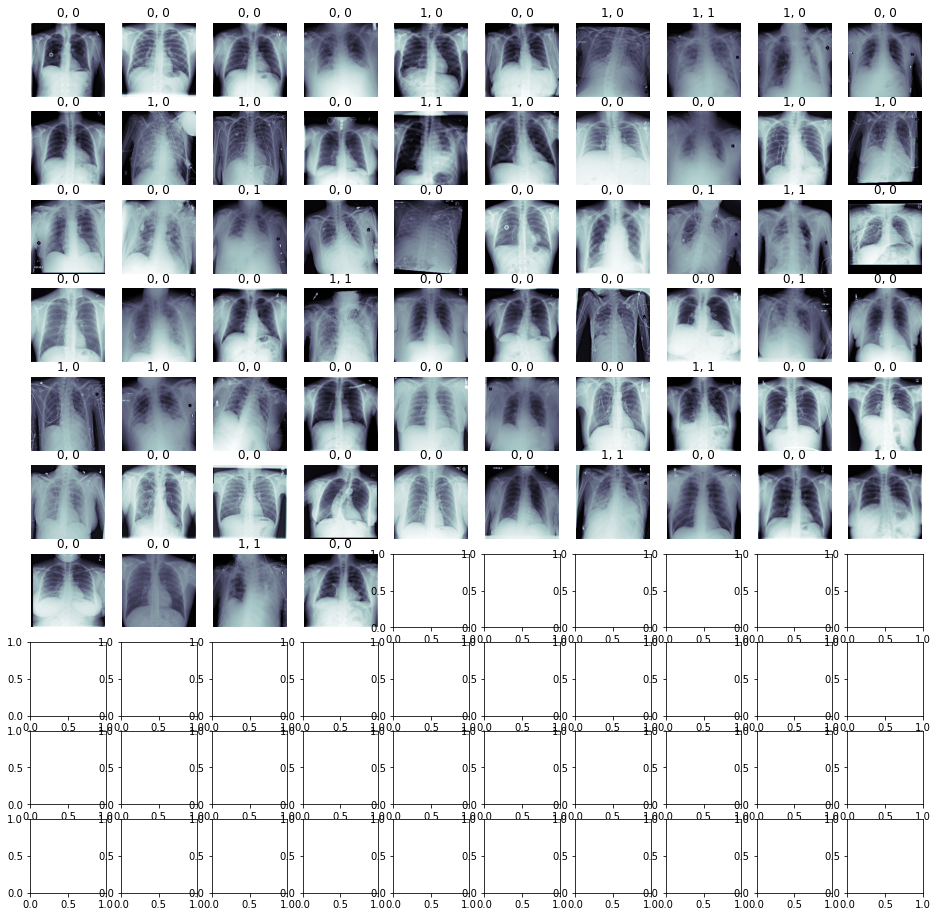

In [20]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > Final_Threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > Final_Threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [18]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model6.json", "w") as json_file:
    json_file.write(model_json)

- Perform the ground truth and checking the performance aganist different disease

In [21]:
import keras
with open('my_model6.json','r') as json_file:
    Model_json = json_file.read()
model = keras.models.model_from_json(Model_json)
model.load_weights("xray_class_my_model6.best.hdf5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 40,406,849
Trainable params: 28,051,969
Non-trainable params: 12,354,880
_________________________________________________________________


In [22]:
#1. Get the prediction labels
prediction_Y = model.predict(valX, batch_size = 64, verbose = True)

accuracy_score(valY, np.round(prediction_Y))*100
print(valY)
print(prediction_Y)

64/64 [==============================] - 1s 11ms/step
[0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
[[0.4230258 ]
 [0.29586738]
 [0.3098473 ]
 [0.56007457]
 [0.35842833]
 [0.2636252 ]
 [0.48509544]
 [0.70573914]
 [0.5653269 ]
 [0.52701837]
 [0.3678572 ]
 [0.50873244]
 [0.5004008 ]
 [0.3024806 ]
 [0.60415876]
 [0.37883556]
 [0.3740647 ]
 [0.5284172 ]
 [0.31339306]
 [0.50261575]
 [0.14796197]
 [0.3260056 ]
 [0.67101467]
 [0.5986275 ]
 [0.5076841 ]
 [0.3891425 ]
 [0.59508586]
 [0.67082876]
 [0.6691092 ]
 [0.29162598]
 [0.26474983]
 [0.5667198 ]
 [0.3458824 ]
 [0.6655339 ]
 [0.24048364]
 [0.31020418]
 [0.5517871 ]
 [0.3742954 ]
 [0.6169198 ]
 [0.24801362]
 [0.5870367 ]
 [0.5966646 ]
 [0.43180907]
 [0.3333078 ]
 [0.16411169]
 [0.20774017]
 [0.16655907]
 [0.6653229 ]
 [0.18258828]
 [0.38300258]
 [0.35717243]
 [0.25440142]
 [0.25089586]
 [0.1874

In [23]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from matplotlib import cm
cm = confusion_matrix(valY,np.round(prediction_Y))
tn, fp, fn, tp = cm.ravel()
print(cm)
print(tp)
print(tn)
print(fp)
print(fn)

[[35 11]
 [ 5 13]]
13
35
11
5


- Printing the percision, recall, accuracy, f1 score for EDA notebook

In [24]:
precision = (tp / (tp + fp))* 100
print('Precision = ',precision)
recall = (tp / (tp + fn))* 100
print('recall = ',recall)
print('F1 score = ',(2*precision*recall/(precision+recall)) )

Precision =  54.166666666666664
recall =  72.22222222222221
F1 score =  61.9047619047619


- Extracting the algorithmic limitation:

In [25]:
pred_class = [0] * len(val_data)
# updating the validation generator
val_asugmented  = ImageDataGenerator(rescale=1. / 255.0)
new_val_gen=val_asugmented.flow_from_dataframe(dataframe = test_data,
                                               directory = None,
                                                x_col = "path",
                                                y_col = "Pneumonia",
#                                                has_ext = True,
                                                target_size= (224,224),
                                                batch_size = 1,
                                                class_mode = "raw", )
valx,valy = new_val_gen.next()
for i in range(1430):
    if model.predict(valx, batch_size =1, verbose = True) > Final_Threshold:
        pred_class[i] = 1

Found 1430 validated image filenames.
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


- Performance of the algorithm in thr presence of the other diseases

In [26]:
import sklearn.metrics
val_data['algorithm_output'] = pred_class
for i in ['Atelectasis','Effusion','Pneumothorax','Infiltration','Cardiomegaly','Mass','Nodule']:

    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(val_data[val_data[i]==1].Pneumonia.values,
                                                  val_data[val_data[i]==1].algorithm_output.values,labels=[1,0]).ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    print(i)
    print('Sensitivity: '+ str(sens))
    print('Specificity: ' +str(spec))
    print()


Atelectasis
Sensitivity: 1.0
Specificity: 0.0

Effusion
Sensitivity: 1.0
Specificity: 0.0

Pneumothorax
Sensitivity: 1.0
Specificity: 0.0

Infiltration
Sensitivity: 1.0
Specificity: 0.0

Cardiomegaly
Sensitivity: 1.0
Specificity: 0.0

Mass
Sensitivity: 1.0
Specificity: 0.0

Nodule
Sensitivity: 1.0
Specificity: 0.0



In [27]:

precision, recall, thresholds = precision_recall_curve(valY, prediction_Y)

precision_value = 0.8
idx1 = (np.abs(precision[-1] - precision_value)).argmin()
print('Precision is: '+ str(precision[idx1]))
print('Recall is: '+ str(recall[idx1]))
print('Threshold is: '+ str(thresholds[idx1]))
print('F1 Score is: ' + str(calc_f1(precision[idx1],recall[idx1])))
thresh1 = thresholds[idx1]

recall_value = 0.8
idx2 = (np.abs(recall[-1] - recall_value)).argmax() 
print('Precision is: '+ str(precision[idx2]))
print('Recall is: '+ str(recall[idx2]))
print('Threshold is: '+ str(thresholds[idx2]))
print('F1 Score is: ' + str(calc_f1(precision[idx2],recall[idx2])))
thresh2 = thresholds[idx2]

Precision is: 0.42857142857142855
Recall is: 1.0
Threshold is: 0.31339306
F1 Score is: 0.6
Precision is: 0.42857142857142855
Recall is: 1.0
Threshold is: 0.31339306
F1 Score is: 0.6
